# Cluster acoustic data

Optional notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- 2-curate_acoustics
- 3-sort_spikes
- 4-curate_spikes
- **5-cluster_acoustics**

Use the environment **birdsong** to run this notebook

In [1]:
%matplotlib inline

import os
import logging
import socket
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import datetime
import copy
import sys
import umap
from sklearn.cluster import KMeans

sys.path.append('/mnt/cube/lo/envs')
from plot_sonogram import plot_sonogram as ps

sys.path.append('/mnt/cube/lo/envs/ceciestunepipe')
from ceciestunepipe.file import bcistructure as et

sys.path.append('/mnt/cube/lo/envs/vocalization-segmentation')
from vocalseg.continuity_filtering import continuity_segmentation, plot_labelled_elements

sys.path.append('/mnt/cube/lo/envs/avgn_paper')
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.utils.hparams import HParams
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram, flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots
from avgn.visualization.projections import scatter_spec
from avgn.visualization.barcodes import plot_sorted_barcodes
from avgn.visualization.network_graph import plot_network_graph

np.set_printoptions(precision=3, suppress=True)

/tmp/ipykernel_4152208/4092762588.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-10-31 13:32:32.208227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 13:32:39.721329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set parameters

In [2]:
# session parameters
sess_par = {
    'bird':'z_c5o30_23', # bird ID
    'sess':'2023-06-15', # session date
    'ephys_software':'sglx', # recording software, sglx or oe
    'stim_sess':False, # if song stimulus was played during the session, ignore detected bouts
    'trim_bouts':True, # manually trim bouts after curation
    'sort':'sort_0', # sort index
}

## Load curated acoustics

In [3]:
sess_epochs = et.list_ephys_epochs(sess_par)
print(f"Found {len(sess_epochs)} epoch(s):", sess_epochs)

Found 1 epoch(s): ['0913_g0']


In [4]:
this_epoch = sess_epochs[0] # set epoch index
epoch_struct = et.sgl_struct(sess_par,this_epoch,ephys_software=sess_par['ephys_software'])
print('Processing epoch', this_epoch)

# load bout dataframe
bout_df_path = os.path.join(epoch_struct['folders']['derived'],'bout_pd_ap0_curated.pkl')
with open(bout_df_path, 'rb') as handle:
    bout_df = pickle.load(handle)

Processing epoch 0913_g0


## Generate and review clustered acoustics

In [6]:
# get sample rate
if len(bout_df.sample_rate.unique()) > 1:
    print(f"{len(bout_df.sample_rate.unique())} sample rates found:", bout_df.sample_rate.unique())
fs = bout_df.sample_rate.unique()[0]

In [7]:
def segment_bout(x: np.array, fs: int) -> dict:
    results = continuity_segmentation(
        x, # audio waveform
        fs, # sampling rate
        n_fft= 512, # FFT window size
        hop_length_ms= 1, # number audio of frames in ms between STFT columns
        win_length_ms= 5, # size of fft window (ms)
        ref_level_db= 20, # reference level dB of audio
        pre= 0.97, # coefficient for preemphasis filter
        min_level_db= -120, # default dB minimum of spectrogram (threshold anything below)
        verbose= True, # display output
        silence_threshold= 0.1, # threshold for spectrogram to consider noise as silence
        spectral_range= [200, 10000], # spectral range to care about for spectrogram
        mask_thresh_std= 1.0, # standard deviations above median to threshold out noise (higher = threshold more noise)
        figsize= (30,3), # size of figure for displaying output (default: {(20, 5)})
        min_silence_for_spec= 0.1, # shortest expected length of silence in a song (used to set dynamic threshold)
        neighborhood_thresh= 0.25, # threshold number of neighborhood time-frequency bins above 0 to consider a bin not noise
        neighborhood_time_ms= 5, # size in ms of neighborhood-continuity filter
        neighborhood_freq_hz= 2000, # size in Hz of neighborhood-continuity filter
        temporal_neighbor_merge_distance_ms= 5, # longest distance at which two elements should be considered one
        overlapping_element_merge_thresh= 0.25, # proportion of temporal overlap to consider two elements one
        min_element_size_ms_hz= [20, 1000] # smallest expected element size (in ms and Hz): everything smaller is removed
    )
    print(results['min_level_db'])
    
    return results

In [8]:
syl_df = bout_df.copy()
syl_df['on_ms'] = None
syl_df['off_ms'] = None
syl_df['on_sample'] = None
syl_df['off_sample'] = None
print(f"{len(syl_df)} bouts need to be segmented")

37 bouts need to be segmented


### Run the following four blocks for every bout in the dataframe
(I'll make this a for loop in the future, but I want to see every segmentation for now)

longest silence 0.10600000000000001
longest vocalization 0.11900000000000022


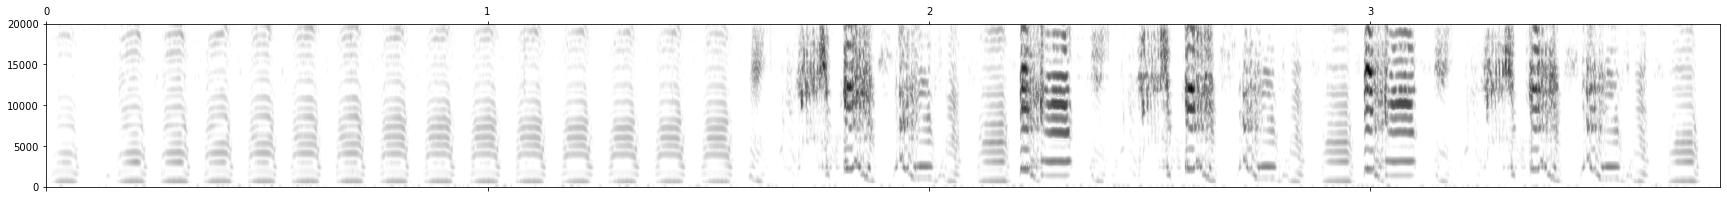

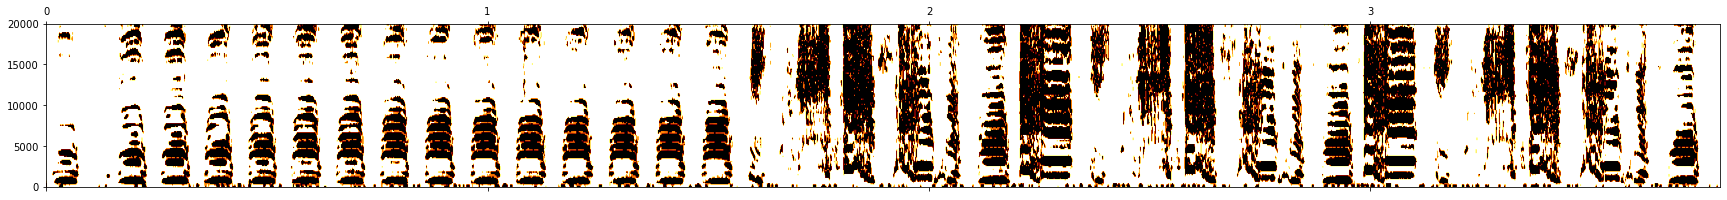

(25, 5)


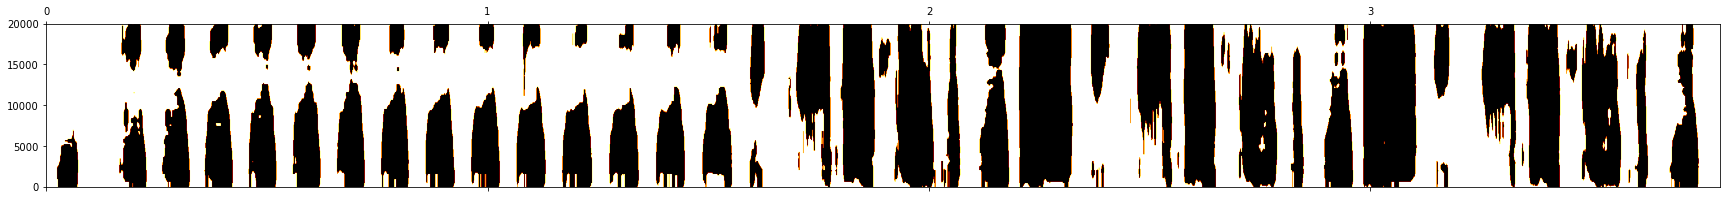

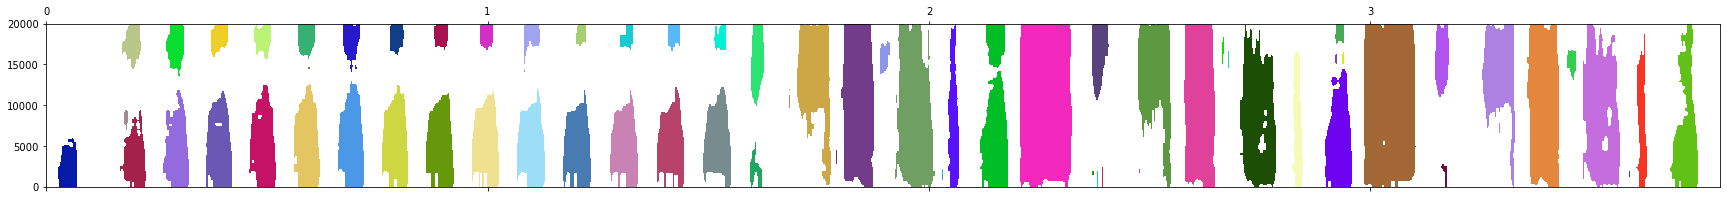

element coverage:   0%|          | 0/84 [00:00<?, ?it/s]

element length:   0%|          | 0/84 [00:00<?, ?it/s]

unique elements: 84


merging temporal neighbors:   0%|          | 0/84 [00:00<?, ?it/s]

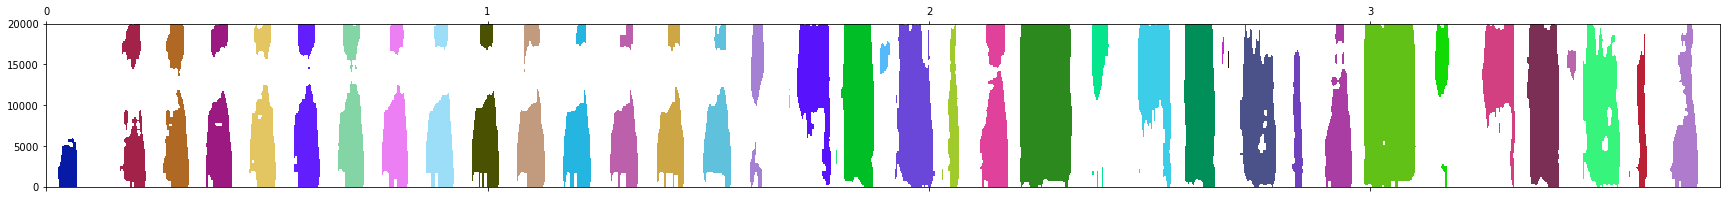

unique elements: 45
257


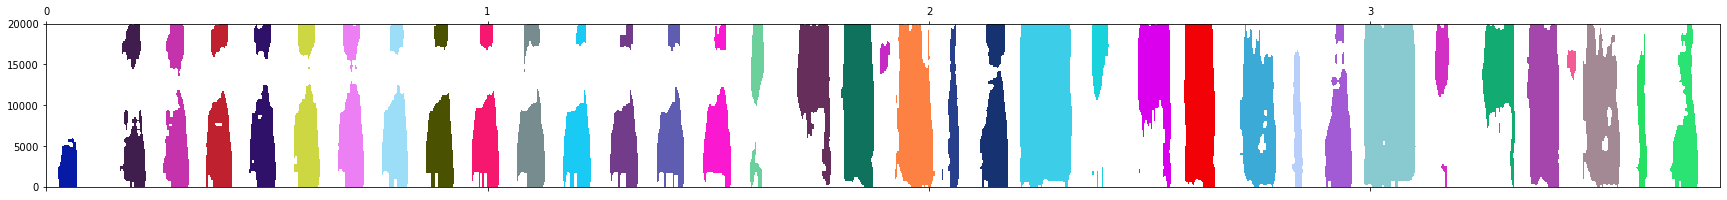

unique elements: 37
-120


In [9]:
bout_idx = 2
x = bout_df.iloc[bout_idx]['waveform'].flatten()
x = x.astype(float)/np.max(np.abs(x))
results = segment_bout(x, fs)

  0%|          | 0/37 [00:00<?, ?it/s]

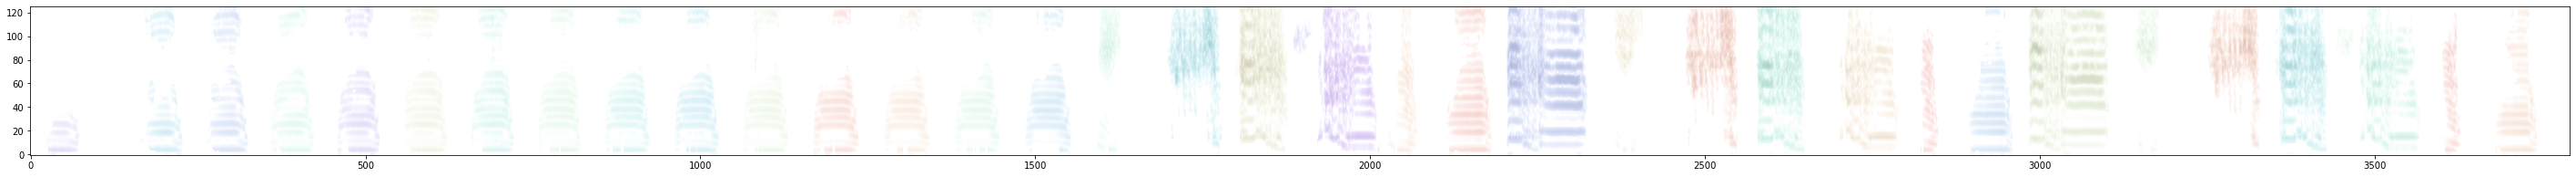

In [10]:
labelled_spec = plot_labelled_elements(results['elements'], results['spec'], figsize=(50,3)); 

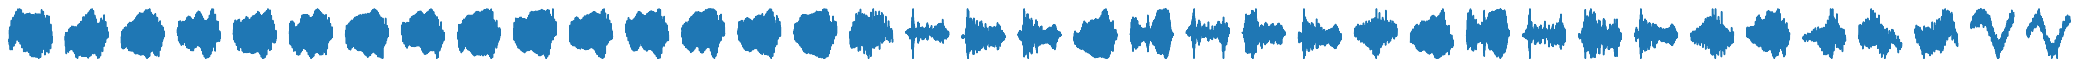

In [11]:
fig, axs = plt.subplots(ncols=len(results['onsets']), figsize= (len(results['onsets']),1))
for axi, (onset, offset) in enumerate(zip(results['onsets'], results['offsets'])):
    axs[axi].plot(x[int(onset*fs):int(offset*fs)])
    axs[axi].axis('off')

In [451]:
# Update syl_df
syl_df.at[bout_idx, 'on_ms'] = (on * 1000).astype(int)
syl_df.at[bout_idx, 'off_ms'] = (off * 1000).astype(int)
syl_df.at[bout_idx, 'on_sample'] = (on * bout_df.at[bout_idx, 'sample_rate']).astype(int)
syl_df.at[bout_idx, 'off_sample'] = (off * bout_df.at[bout_idx, 'sample_rate']).astype(int)

#### Option to listen to a bout

In [12]:
ipd.Audio(bout_df.iloc[bout_idx]['waveform'],rate=bout_df.iloc[bout_idx]['sample_rate'])

### Process segmented syllables

In [456]:
# Bandpass filter waveforms
syl_df['waveform_filt'] = syl_df.apply(lambda r: butter_bandpass_filter(r['waveform'], 300, 12000, r['sample_rate']), axis=1)
syl_df.rename(columns={'waveform': 'waveform_raw'}, inplace=True)

In [464]:
syl_df.keys()

Index(['file', 'start_sample', 'end_sample', 'start_ms', 'end_ms', 'len_ms',
       'waveform_raw', 'spectrogram', 'sample_rate', 'valid_waveform', 'valid',
       'start_ms_ap_0', 'start_sample_ap_0', 'start_sample_naive', 'bird',
       'sess', 'epoch', 'bout_check', 'confusing', 'is_call', 'on_ms',
       'off_ms', 'on_sample', 'off_sample', 'waveform_filt'],
      dtype='object')

In [474]:
# Create a dataframe for segmented syllables
dfs = []
for index, row in syl_df.iterrows():
    file = row['file']
    sess = row['sess']
    epoch = row['epoch']
    sample_rate = row['sample_rate']
    bout_index = index
    waveform_raw = row['waveform_raw']
    waveform_filt = row['waveform_filt']
    start_ms_ap_0 = row['start_ms_ap_0']
    start_sample_ap_0 = row['start_sample_ap_0']
    on_samples = row['on_sample']
    off_samples = row['off_sample']
    on_mss = row['on_ms']
    off_mss = row['off_ms']
    
    data = []
    for syllable_index, (on_sample, 
                         off_sample, 
                         on_ms, 
                         off_ms) in enumerate( zip(on_samples, 
                                                   off_samples, 
                                                   on_mss, 
                                                   off_mss)
                                             ):
        data.append({
            'file': file,
            'sess': sess,
            'epoch': epoch,
            'sample_rate': sample_rate,
            'bout_index': bout_index,
            'waveform_raw': waveform_raw,
            'waveform_filt': waveform_filt,
            'start_ms_ap_0': start_ms_ap_0,
            'start_sample_ap_0': start_sample_ap_0,
            'syllable_index': syllable_index,
            'on_sample': on_sample,
            'off_sample': off_sample,
            'on_ms': on_ms,
            'off_ms': off_ms,
            'syllable_waveform': waveform_filt[on_sample:off_sample]})
    
    df = pd.DataFrame(data)
    dfs.append(df)

syl_seg_df = pd.concat(dfs, ignore_index=True)

In [490]:
# remove empty syllables (product of errors in segmentation)
empty_rows = []
for i, arr in enumerate(syl_seg_df.syllable_waveform.values):
    if len(arr) == 0: empty_rows.append(i)
if empty_rows:
    print('Bouts with empty syllables:', syl_seg_df.iloc[empty_rows]['bout_index'].unique())

syl_seg_df = syl_seg_df[syl_seg_df['syllable_waveform'].apply(lambda x: len(x) != 0)]

In [491]:
# normalize audio
syl_seg_df['syllable_waveform'] = [syll/max(np.min(syll), np.max(syll), key=abs) for i, syll in enumerate(syl_seg_df['syllable_waveform'].values)]
syl_seg_df['syllable_waveform'] = [np.nan_to_num(syll) if not np.all(np.isfinite(syll)) else syll for syll in syl_seg_df['syllable_waveform'].values]

  0%|          | 0/100 [00:00<?, ?it/s]

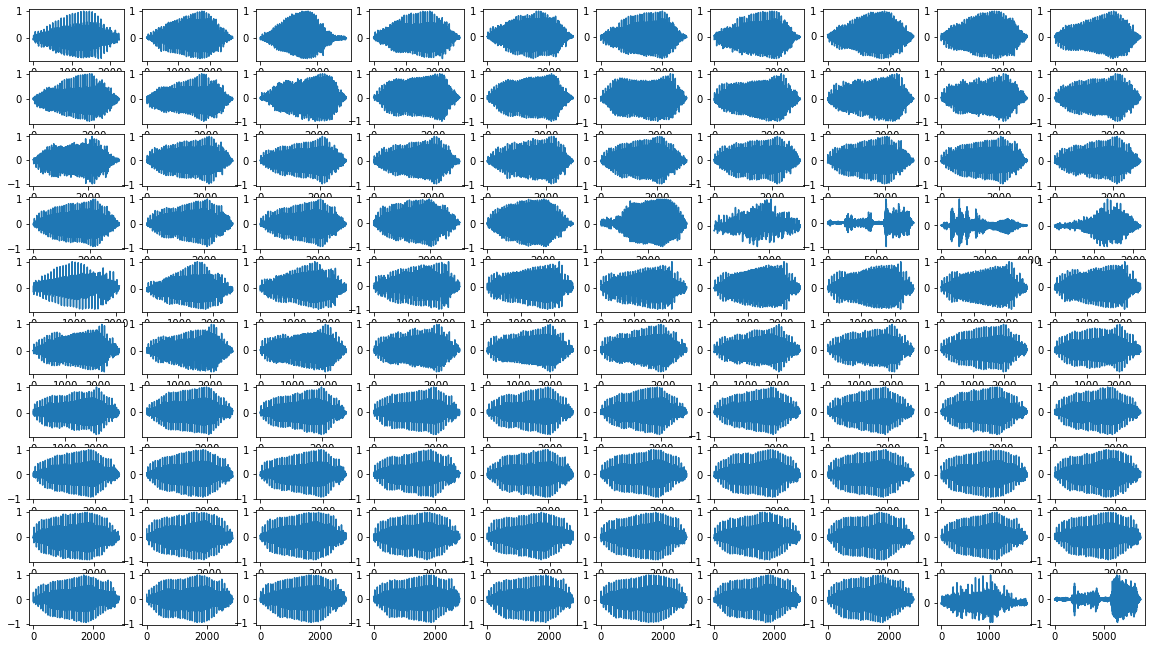

In [492]:
# Plot some of the syllables to see how they look
nrows = 10
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows, figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(syl_seg_df['syllable_waveform'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols-1:
        break

### Perform UMAP and clustering

In [493]:
syllables_wav = syl_seg_df.syllable_waveform.values
syllables_rate = syl_seg_df.sample_rate.values

In [494]:
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=300,
    mel_upper_edge_hertz=12000,
    butter_lowcut = 300,
    butter_highcut = 12000,
    ref_level_db = 20,
    min_level_db = -100,
    mask_spec = True,
    win_length_ms = 4,
    hop_length_ms = 1,
    nex = -1,
    n_jobs = -1,
    verbosity = 0,
)

In [495]:
n_jobs = 36
verbosity = 0

In [496]:
# create spectrograms
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=hparams,
            mel_matrix=prepare_mel_matrix(hparams, rate),
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

getting syllable spectrograms:   0%|          | 0/825 [00:00<?, ?it/s]

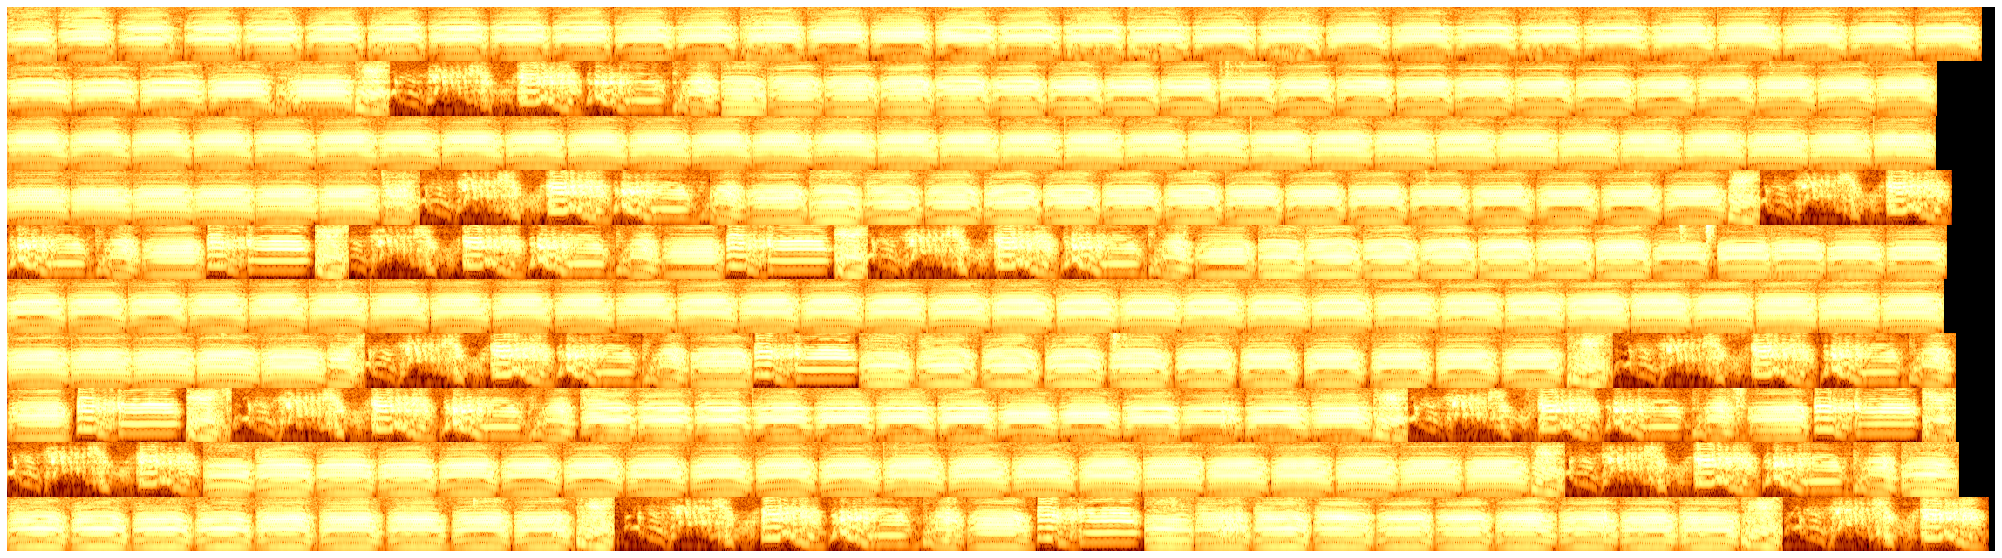

In [497]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=40)

In [498]:
# log rescale spectrograms
log_scaling_factor = 4

with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

scaling spectrograms:   0%|          | 0/825 [00:00<?, ?it/s]

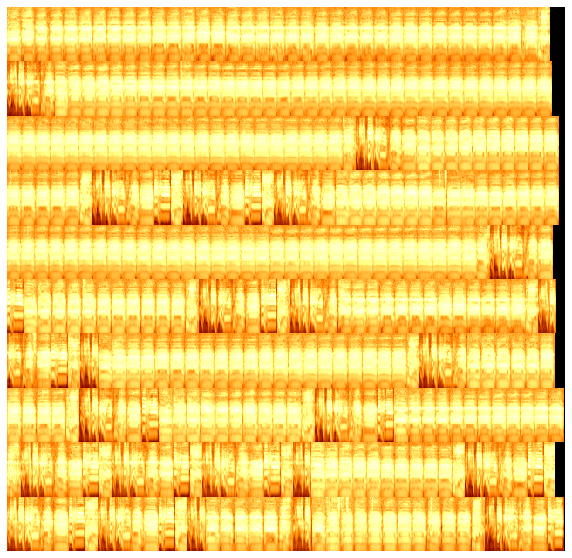

In [499]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=40)

In [500]:
syl_seg_df['spec'] = syllables_spec
syl_seg_df.head(2)

file        sess    epoch  \
0  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...  2023-06-15  0913_g0   
1  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...  2023-06-15  0913_g0   

   sample_rate  bout_index                                       waveform_raw  \
0        40000           0  [14, 23, 19, 16, -2, 37, 51, 49, 42, 20, 37, 3...   
1        40000           0  [14, 23, 19, 16, -2, 37, 51, 49, 42, 20, 37, 3...   

                                       waveform_filt  start_ms_ap_0  \
0  [3.3851349619418847, 13.522975407927271, 20.71...         919480   
1  [3.3851349619418847, 13.522975407927271, 20.71...         919480   

   start_sample_ap_0  syllable_index  on_sample  off_sample  on_ms  off_ms  \
0           27584486               0       1719        3959     42      98   
1           27584486               1       6440        9160    161     229   

                                   syllable_waveform  \
0  [-0.034488649116835836, -0.059918455983019384,...   
1  [0.003013454440532701, 0.0004934050405322425, ...   

                                                spec  
0  [[0.5032329, 0.5101386, 0.534852, 0.60798085, ...  
1  [[0.4163593, 0.4622229, 0.41654333, 0.5271921,...

#### Pad spectrograms

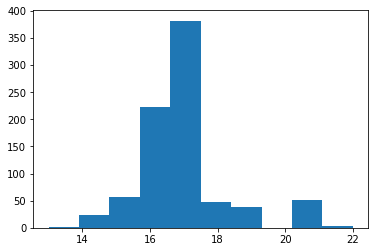

In [502]:
# plot length of syllables
syll_lens = [np.shape(i)[1] for i in syl_seg_df['spec']]
plt.hist(syll_lens);

In [503]:
# normalize spectrograms
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# convert to uint8 to save space
specs = list(syl_seg_df.spec.values)
syllables_spec = [(norm(syll)*255).astype('uint8') for syll in specs]
# syllables_spec = [np.nan_to_num(syll) for syll in specs]

# pad spectrogram
all_syl_len = [s.shape[-1] for s in syllables_spec]
pad_len = np.max(all_syl_len)
syl_seg_df['processed_spec'] = [pad_spectrogram(spec, pad_len) for spec in syllables_spec]
print('All syllables padded to',pad_len)

All syllables padded to 22


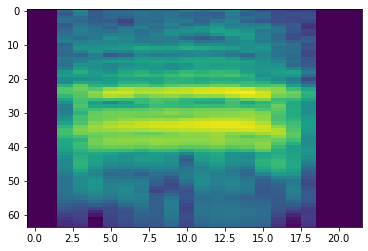

In [504]:
# plot padded syllable
plt.imshow(syl_seg_df.iloc[18]['processed_spec'][::-1], aspect='auto')

#### Embed and cluster spectrograms

In [528]:
# Cluster spectrograms using UMAP
specs = list(syl_seg_df.processed_spec.values)

# flatten the spectrograms into 1D
specs_flattened = flatten_spectrograms(specs)

# fit UMAP
fit = umap.UMAP(min_dist = 0.2, n_neighbors = 20, verbose = True)
z = list(fit.fit_transform(specs_flattened))
syl_seg_df['umap'] = z
z = np.vstack(z)

UMAP(min_dist=0.2, n_neighbors=20, verbose=True)
Fri Mar  8 14:41:37 2024 Construct fuzzy simplicial set
Fri Mar  8 14:41:38 2024 Finding Nearest Neighbors
Fri Mar  8 14:41:38 2024 Finished Nearest Neighbor Search
Fri Mar  8 14:41:38 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Mar  8 14:41:43 2024 Finished embedding


In [529]:
# Cluster spectrograms using UMAP
specs = list(syl_seg_df.processed_spec.values)

# flatten the spectrograms into 1D
specs_flattened = flatten_spectrograms(specs)

In [539]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(z)

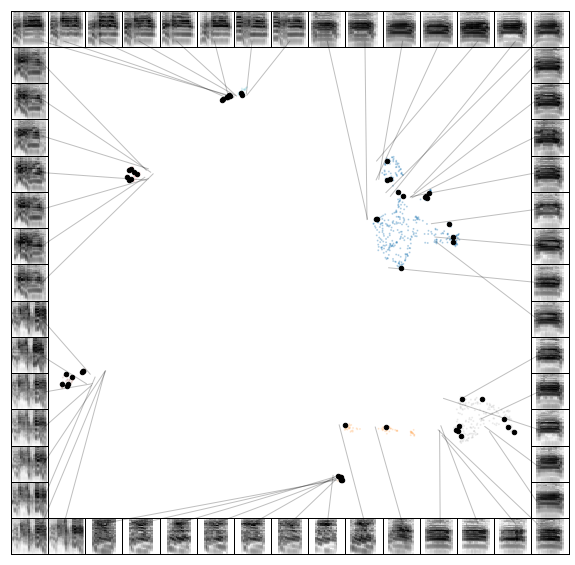

In [540]:
# display labeled clusters
scatter_spec(
        np.vstack(z),
        specs,
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': clusters,
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
plt.show()

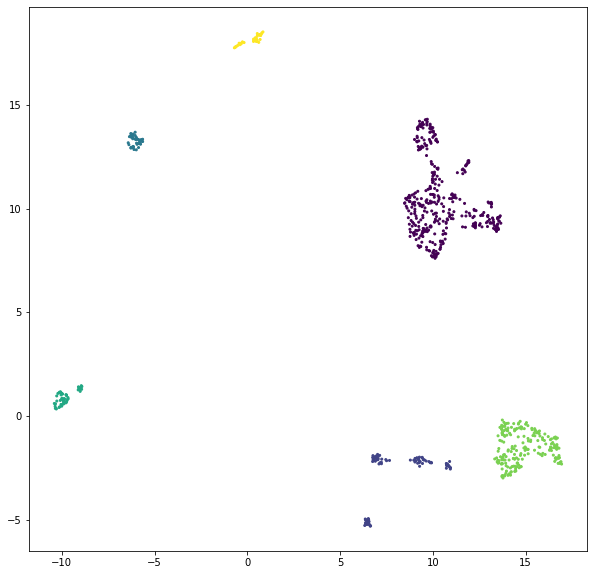

In [541]:
plt.figure(figsize=(10,10))
plt.scatter(z[:, 0], z[:, 1], c=clusters, cmap='viridis', s=4)

In [542]:
syl_seg_df['label_orig'] = clusters

/mnt/cube/lo/envs/plot_sonogram.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')


4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 1, 3, 2, 1, 0, 5, 1, 3, 2, 1, 0, 5, 1, 3, 2, 1, 0, 5, 1, 3


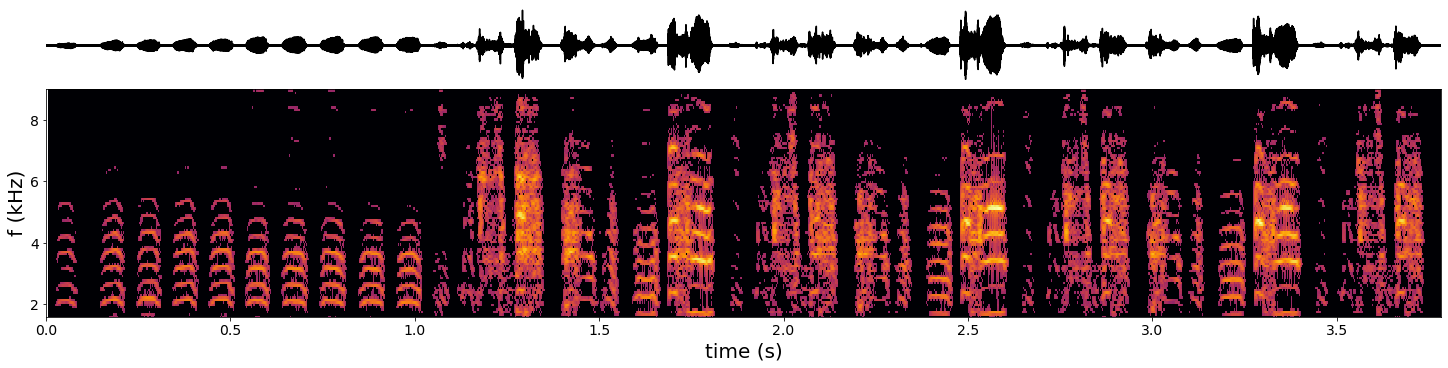

In [549]:
ref_id = 9
fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1,3]}, figsize=(20, 5), constrained_layout=True)
bout_idx = syl_seg_df[syl_seg_df['bout_index']==ref_id].index.values[0]
ps(syl_seg_df.loc[bout_idx,'waveform_raw'].flatten(), syl_df.iloc[ref_id]['sample_rate'], fig, ax)
umap_syls = syl_seg_df[syl_seg_df['bout_index']==ref_id].label_orig.values
print(', '.join(map(str, umap_syls)))

In [553]:
transformation_mapping = {
    (4,0): 0,
    (1,): 1,
    (3,): 2,
    (2,): 3,
    (5,): 4
}

clusters_checked = [value for cluster in clusters for key, value in transformation_mapping.items() if cluster in key]
syl_seg_df['label'] = clusters_checked
print('Number of syllables:',len(syl_seg_df['label'].unique()))

Number of syllables: 5


### Plot syllable barcodes

In [554]:
def song_barcode(start_times, stop_times, labels, label_dict, label_pal_dict, resolution=0.01):
    begin = np.min(start_times)
    end = np.max(stop_times)
    trans_list = (
        np.zeros(int((end - begin) / resolution)).astype("str").astype("object")
    )
    # print(end, begin, end-begin, resolution, len(trans_list))
    for start, stop, label in zip(start_times, stop_times, labels):
        trans_list[
            int((start - begin) / resolution) : int((stop - begin) / resolution)
        ] = label_dict[label]

    color_list = [
        label_pal_dict[i] if i in label_pal_dict else [1, 1, 1] for i in trans_list
    ]
    color_list = np.expand_dims(color_list, 1)

    return trans_list, color_list


def indv_barcode(this_df, time_resolution=0.01, label="label", pal="tab20"):
    unique_labels = this_df[label].unique()
    
    # song palette
    label_pal = np.random.permutation(sns.color_palette(pal, len(unique_labels)))
    label_dict = {lab: str(int(i)).zfill(3) for i, lab in enumerate(unique_labels)}

    label_pal_dict = {
        label_dict[lab]: color for lab, color in zip(unique_labels, label_pal)
    }
    sns.palplot(list(label_pal_dict.values()))

    # get list of syllables by time
    trans_lists = []
    color_lists = []
    for key in tqdm(this_df.bout_index.unique(), leave=False):
        # dataframe of wavs
        wav_df = this_df[this_df['bout_index'] == key]
        labels = wav_df[label].values
        start_times = wav_df.on_ms.values
        stop_times = wav_df.off_ms.values
        trans_list, color_list = song_barcode(
            start_times,
            stop_times,
            labels,
            label_dict,
            label_pal_dict,
            resolution=time_resolution,
        )
        color_lists.append(color_list)
        trans_lists.append(trans_list)

    return color_lists, trans_lists, label_pal_dict, label_pal, label_dict

Syllable barcodes: [0 1 2 3 4]


  0%|          | 0/37 [00:00<?, ?it/s]

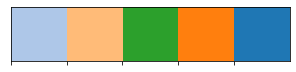

In [584]:
# Get variables for plotting
print('Syllable barcodes: ' + str(syl_seg_df.label.unique()))

color_lists, trans_lists, label_pal_dict, label_pal, label_dict = indv_barcode(
    syl_seg_df,
    time_resolution=12
)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/666 [00:00<?, ?it/s]

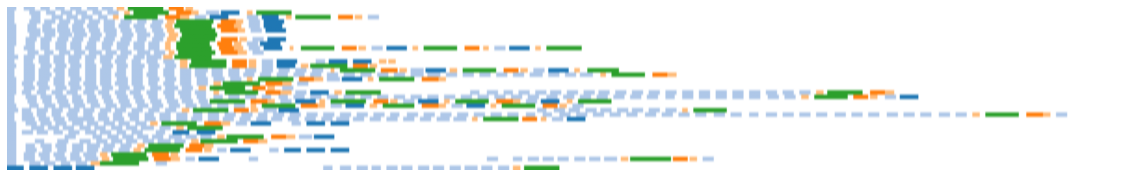

In [585]:
# Plot syllable barcodes for songs
ids = syl_seg_df.bout_index.unique()

fig, ax = plt.subplots(figsize=(20, 3))
plot_sorted_barcodes(
    [color_lists[i] for i in ids],
    [trans_lists[i] for i in ids],
    max_list_len=600,
    seq_len=100,
    nex=200,
    figsize=(10, 4),
    ax=ax,
)
plt.show()

## Save syl_df

In [586]:
syl_df.to_pickle(os.path.join(epoch_struct['folders']['derived'],'syl_df_ap0.pickle'))

In [587]:
syl_seg_df.to_pickle(os.path.join(epoch_struct['folders']['derived'],'syl_seg_df_ap0.pickle'))

In [5]:
with open(os.path.join(epoch_struct['folders']['derived'],'syl_df_ap0.pickle'),'rb') as f:
    syl_df = pickle.load(f)

In [6]:
with open(os.path.join(epoch_struct['folders']['derived'],'syl_seg_df_ap0.pickle'),'rb') as f:
    syl_seg_df = pickle.load(f)

In [10]:
syl_df.head(3)

file  start_sample  \
0  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...      36778640   
1  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...      39279960   
2  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...      40956840   

   end_sample  start_ms   end_ms  len_ms  \
0    36955680    919466   923892    4426   
1    39558280    981999   988957    6958   
2    41108480   1023921  1027712    3791   

                                        waveform_raw  \
0  [14, 23, 19, 16, -2, 37, 51, 49, 42, 20, 37, 3...   
1  [-213, -203, -161, -186, -184, -195, -218, -19...   
2  [-285, -247, -295, -274, -335, -276, -255, -25...   

                                         spectrogram  sample_rate  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        40000   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        40000   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        40000   

   valid_waveform  ...        sess    epoch  bout_check  confusing is_call  \
0            True  ...  2023-06-15  0913_g0        True      False   False   
1            True  ...  2023-06-15  0913_g0        True      False   False   
2            True  ...  2023-06-15  0913_g0        True      False   False   

                                               on_ms  \
0  [42, 161, 256, 354, 449, 548, 649, 748, 850, 9...   
1  [36, 139, 236, 333, 430, 529, 627, 727, 827, 9...   
2  [15, 161, 260, 358, 457, 555, 656, 757, 856, 9...   

                                              off_ms  \
0  [98, 229, 332, 421, 520, 619, 718, 818, 919, 1...   
1  [88, 204, 299, 395, 494, 593, 691, 791, 893, 9...   
2  [76, 230, 327, 425, 524, 625, 725, 824, 928, 1...   

                                           on_sample  \
0  [1719, 6440, 10279, 14160, 18000, 21959, 25960...   
1  [1440, 5560, 9440, 13320, 17200, 21160, 25080,...   
2  [600, 6440, 10400, 14320, 18280, 22200, 26240,...   

                                          off_sample  \
0  [3959, 9160, 13319, 16840, 20800, 24760, 28720...   
1  [3520, 8159, 11960, 15800, 19760, 23720, 27639...   
2  [3040, 9200, 13080, 17000, 20960, 25000, 29000...   

                                       waveform_filt  
0  [3.3851349619418847, 13.522975407927271, 20.71...  
1  [-51.50241049240153, -170.21576555981972, -200...  
2  [-68.9116760109598, -221.80055561477445, -273....  

[3 rows x 25 columns]

In [11]:
syl_seg_df.head(3)

file        sess    epoch  \
0  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...  2023-06-15  0913_g0   
1  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...  2023-06-15  0913_g0   
2  /mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06...  2023-06-15  0913_g0   

   sample_rate  bout_index                                       waveform_raw  \
0        40000           0  [14, 23, 19, 16, -2, 37, 51, 49, 42, 20, 37, 3...   
1        40000           0  [14, 23, 19, 16, -2, 37, 51, 49, 42, 20, 37, 3...   
2        40000           0  [14, 23, 19, 16, -2, 37, 51, 49, 42, 20, 37, 3...   

                                       waveform_filt  start_ms_ap_0  \
0  [3.3851349619418847, 13.522975407927271, 20.71...         919480   
1  [3.3851349619418847, 13.522975407927271, 20.71...         919480   
2  [3.3851349619418847, 13.522975407927271, 20.71...         919480   

   start_sample_ap_0  syllable_index  ...  label_orig  label  duration_ms  \
0           27584486               0  ...           4      0           56   
1           27584486               1  ...           4      0           68   
2           27584486               2  ...           0      0           76   

                                                  f0  \
0  [525.3561668435311, 540.7502775664981, 543.882...   
1  [493.0141887514742, 537.6357851471714, 553.389...   
2  [nan, 550.2024259228027, 556.5954701647858, 55...   

                                           mean_freq  \
0  [2479.6318876837963, 2479.5869596466646, 2470....   
1  [2832.560229112974, 2899.5090834358793, 2938.4...   
2  [2755.020615371183, 2846.292909025462, 2877.64...   

                                           amplitude  \
0  [143.27679854240318, 144.39858516668593, 145.3...   
1  [144.49206284367574, 146.26663331306088, 147.8...   
2  [144.2056433642707, 146.12090270642864, 147.92...   

                                            goodness  \
0  [0.10259739092556909, 0.14397099678767095, 0.1...   
1  [0.20561146103683567, 0.20486051174835548, 0.1...   
2  [0.111279747049674, 0.14580015887779169, 0.148...   

                                                  FM  \
0  [0.7879531835604661, 0.7879531835604661, 0.787...   
1  [0.7879531835604661, 0.7879531835604661, 0.787...   
2  [0.7879531835604661, 0.7879531835604661, 0.787...   

                                                  AM  \
0  [2584544.6849159594, 3156681.601859254, 361846...   
1  [4496961.870308619, 5987643.710685434, 8064415...   
2  [4914220.5674833665, 7137293.607432798, 975089...   

                                             entropy  
0  [-1.891032298654375, -1.991935816617417, -2.06...  
1  [-1.7842421751760806, -1.868247029859285, -1.7...  
2  [-1.8719154057561873, -2.0816475598860418, -2....  

[3 rows x 28 columns]